In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from math import sqrt, pi, exp
import scipy.linalg
import time
import matplotlib.pylab as pl
from scipy.sparse.linalg import eigs
import math
import functools
from matplotlib.cm import get_cmap
from preconditioners.preconditioners import * 

## Example of Section 4.1 of Arnold and Signorello

In [2]:
# parameters of the target
K     = np.diag([1,2]) # target e^{-1/2 u K^-1 u}
sqrtK = np.diag([1,sqrt(2)])#  % K^1/2
d = 2

### Test that we obtain the same values of Copt, Dopt etc: all good

In [3]:
const = 1.5  # a user-specified const(>1) for the prefactor of convergence
mu = (const**2+1)/(const**2-1) # mu=2.6 for c=1.5


# test : we obtain the same values than in Arnold and Signorello section 4.1, good
D_opt_tilde, v, lambda_min = construct_D_opt_tilde(K,d)
print("v")
print(v)
print()
print("lambda_min")
print(lambda_min) # recall that lambda_min is the maximum decay rate 
print()
D_opt = construct_D_opt(K,d)
print("D opt")
print(D_opt)
print()



psis = construct_onb(d,v)
print("psis")
print(psis)
print()

J_opt_tilde = construct_J_opt_tilde(psis, v, lambda_min, const, d) 
print("J opt_tilde")
print(J_opt_tilde)
print()

J_opt = construct_J_opt(psis, v, lambda_min, const, d, sqrtK) 
print("J opt")
print(J_opt)
print()

C_opt = np.dot(D_opt + J_opt, np.linalg.inv(K))
print("C opt")
print(C_opt)
print()
print("mu over sqrt 2")
print(mu/sqrt(2))
print()

C_opt_tilde = J_opt_tilde+D_opt_tilde
print("C opt tilde")
print(C_opt_tilde)


v
[1. 0.]

lambda_min
1.0

D opt
[[2. 0.]
 [0. 0.]]

psis
[[ 0.70710678  0.70710678]
 [-0.70710678  0.70710678]]

J opt_tilde
[[ 0.   2.6]
 [-2.6  0. ]]

J opt
[[ 0.          3.67695526]
 [-3.67695526  0.        ]]

C opt
[[ 2.          1.83847763]
 [-3.67695526  0.        ]]

mu over sqrt 2
1.8384776310850235

C opt tilde
[[ 2.   2.6]
 [-2.6  0. ]]


### run their scheme and our scheme 

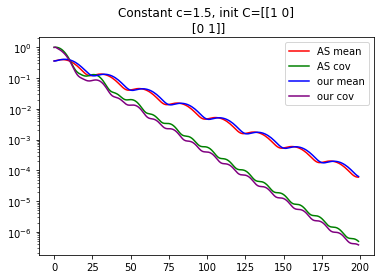

In [4]:
# parameters of the algorithm
const = 1.5  # a user-specified const(>1) for the prefactor of convergence
N     = 200   # iteration number 
dt    = 0.05 # step size

# initialization
m0  = np.asarray([0.2,0.3]).T 
C0  = np.diag([1,1])



# OPTIMAL (Arnold and Signorello scheme)
# means and covariances along iterations for the optimal scheme
MM_opt = np.zeros((2,N))
CC_opt = np.zeros((2,2,N))


# distances to true mean and true covariance along iterations
dis_M_opt  = np.zeros((N,1)) 
dis_C_opt  = np.zeros((N,1))
dis_L2_opt = np.zeros((N,1))

# initialization

MM_opt[:,0]   = m0
CC_opt[:,:,0] = C0

dis_M_opt[0] = np.linalg.norm(m0)
dis_C_opt[0] = np.linalg.norm(C0-K)

# construct D_opt and J_opt matrices
D_opt_tilde, v, lambda_min = construct_D_opt_tilde(K,d)
D_opt = construct_D_opt(K,d)

psis = construct_onb(d,v)
J_opt = construct_J_opt(psis, v, lambda_min, const, d, sqrtK) 
    
m, C = m0, C0
for iter in range(1,N):
    m = m - dt*np.dot((D_opt + J_opt),np.linalg.solve(K,m)) # li has a "d - j" below and has a multiplication by C in the end
    C   = C - dt*np.dot((D_opt + J_opt),np.linalg.solve(K,C)) \
                - dt*np.dot(C, np.linalg.solve(K,(D_opt+J_opt).T)) + 2*dt*D_opt
    MM_opt[:,iter]    = m
    CC_opt[:,:,iter]  = C
    #dis_L2[iter] = weighted_L2(m, C, [0,0]', K)
    dis_M_opt[iter] = np.linalg.norm(m)
    dis_C_opt[iter] = np.linalg.norm(C-K)

# OUR SCHEME
#for our scheme D opt and J opt are computed from the current covariance C

# means and covariances along iterations for our scheme
MM = np.zeros((2,N))
CC = np.zeros((2,2,N))


# distances to true mean and true covariance along iterations
dis_M = np.zeros((N,1)) 
dis_C  = np.zeros((N,1))
dis_L2 = np.zeros((N,1))


# initialization
MM[:,0]   = m0
CC[:,:,0] = C0

dis_M[0] = np.linalg.norm(m0)
dis_C[0] = np.linalg.norm(C0-K)

m, C = m0, C0
for iter in range(1,N):
    # construct D_opt and J_opt matrices
    D_opt_tilde, v, lambda_min = construct_D_opt_tilde(C,d)
    D_opt = construct_D_opt(C,d)

    psis = construct_onb(d,v)
    sqrtC = scipy.linalg.sqrtm(C)
    J_opt = construct_J_opt(psis, v, lambda_min, const, d, sqrtC) 

    #print(iter)
    m = m - dt*np.dot((D_opt + J_opt),np.linalg.solve(K,m)) # li has a "d - j" below and has a multiplication by C in the end
    C   = C - dt*np.dot((D_opt + J_opt),np.linalg.solve(K,C)) \
                - dt*np.dot(C, np.linalg.solve(K,(D_opt+J_opt).T)) + 2*dt*D_opt
    MM[:,iter]    = m
    CC[:,:,iter]  = C
    #dis_L2[iter] = weighted_L2(m, C, [0,0]', K)
    dis_M[iter] = np.linalg.norm(m)
    dis_C[iter] = np.linalg.norm(C-K)
    
plt.yscale('log',base=10) 
plt.plot(range(0,N), dis_M_opt, c='red', label = 'AS mean')
plt.plot(range(0,N), dis_C_opt, c='green', label = 'AS cov')
plt.plot(range(0,N), dis_M, c='blue', label = 'our mean')
plt.plot(range(0,N), dis_C, c='purple', label = 'our cov')
plt.title('Constant c='+str(const)+', init C='+str(C0))
plt.legend()

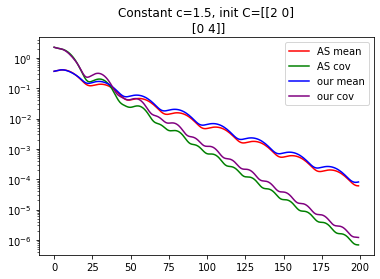

In [5]:
# parameters of the algorithm
const = 1.5  # a user-specified const(>1) for the prefactor of convergence
N     = 200   # iteration number 
dt    = 0.05 # step size

# initialization
m0  = np.asarray([0.2,0.3]).T 
C0  = np.diag([2,4])



# OPTIMAL (Arnold and Signorello scheme)
# means and covariances along iterations for the optimal scheme
MM_opt = np.zeros((2,N))
CC_opt = np.zeros((2,2,N))


# distances to true mean and true covariance along iterations
dis_M_opt  = np.zeros((N,1)) 
dis_C_opt  = np.zeros((N,1))
dis_L2_opt = np.zeros((N,1))

# initialization

MM_opt[:,0]   = m0
CC_opt[:,:,0] = C0

dis_M_opt[0] = np.linalg.norm(m0)
dis_C_opt[0] = np.linalg.norm(C0-K)

# construct D_opt and J_opt matrices
D_opt_tilde, v, lambda_min = construct_D_opt_tilde(K,d)
D_opt = construct_D_opt(K,d)

psis = construct_onb(d,v)
J_opt = construct_J_opt(psis, v, lambda_min, const, d, sqrtK) 
    
m, C = m0, C0
for iter in range(1,N):
    m = m - dt*np.dot((D_opt + J_opt),np.linalg.solve(K,m)) # li has a "d - j" below and has a multiplication by C in the end
    C   = C - dt*np.dot((D_opt + J_opt),np.linalg.solve(K,C)) \
                - dt*np.dot(C, np.linalg.solve(K,(D_opt+J_opt).T)) + 2*dt*D_opt
    MM_opt[:,iter]    = m
    CC_opt[:,:,iter]  = C
    #dis_L2[iter] = weighted_L2(m, C, [0,0]', K)
    dis_M_opt[iter] = np.linalg.norm(m)
    dis_C_opt[iter] = np.linalg.norm(C-K)

# OUR SCHEME
#for our scheme D opt and J opt are computed from the current covariance C

# means and covariances along iterations for our scheme
MM = np.zeros((2,N))
CC = np.zeros((2,2,N))


# distances to true mean and true covariance along iterations
dis_M = np.zeros((N,1)) 
dis_C  = np.zeros((N,1))
dis_L2 = np.zeros((N,1))


# initialization
MM[:,0]   = m0
CC[:,:,0] = C0

dis_M[0] = np.linalg.norm(m0)
dis_C[0] = np.linalg.norm(C0-K)

m, C = m0, C0
for iter in range(1,N):
    # construct D_opt and J_opt matrices
    D_opt_tilde, v, lambda_min = construct_D_opt_tilde(C,d)
    D_opt = construct_D_opt(C,d)

    psis = construct_onb(d,v)
    sqrtC = scipy.linalg.sqrtm(C)
    J_opt = construct_J_opt(psis, v, lambda_min, const, d, sqrtC) 

    #print(iter)
    m = m - dt*np.dot((D_opt + J_opt),np.linalg.solve(K,m)) # li has a "d - j" below and has a multiplication by C in the end
    C   = C - dt*np.dot((D_opt + J_opt),np.linalg.solve(K,C)) \
                - dt*np.dot(C, np.linalg.solve(K,(D_opt+J_opt).T)) + 2*dt*D_opt
    MM[:,iter]    = m
    CC[:,:,iter]  = C
    #dis_L2[iter] = weighted_L2(m, C, [0,0]', K)
    dis_M[iter] = np.linalg.norm(m)
    dis_C[iter] = np.linalg.norm(C-K)
    
plt.yscale('log',base=10) 
plt.plot(range(0,N), dis_M_opt, c='red', label = 'AS mean')
plt.plot(range(0,N), dis_C_opt, c='green', label = 'AS cov')
plt.plot(range(0,N), dis_M, c='blue', label = 'our mean')
plt.plot(range(0,N), dis_C, c='purple', label = 'our cov')
plt.title('Constant c='+str(const)+', init C='+str(C0))
plt.legend()

In [6]:
# there is a numerical issue if C0 is initialized as follows ("wrong angle computed")

"""
# parameters of the algorithm
const = 1.5  # a user-specified const(>1) for the prefactor of convergence
N     = 200   # iteration number 
dt    = 0.05 # step size

# initialization
m0  = np.asarray([0.2,0.3]).T 
C0  = np.diag([2,1])


# OPTIMAL (Arnold and Signorello scheme)
# means and covariances along iterations for the optimal scheme
MM_opt = np.zeros((2,N))
CC_opt = np.zeros((2,2,N))


# distances to true mean and true covariance along iterations
dis_M_opt  = np.zeros((N,1)) 
dis_C_opt  = np.zeros((N,1))
dis_L2_opt = np.zeros((N,1))

# initialization

MM_opt[:,0]   = m0
CC_opt[:,:,0] = C0

dis_M_opt[0] = np.linalg.norm(m0)
dis_C_opt[0] = np.linalg.norm(C0-K)

# construct D_opt and J_opt matrices
D_opt_tilde, v, lambda_min = construct_D_opt_tilde(K,d)
D_opt = construct_D_opt(K,d)

psis = construct_onb(d,v)
J_opt = construct_J_opt(psis, v, lambda_min, const, d, sqrtK) 
    
m, C = m0, C0
for iter in range(1,N):
    m = m - dt*np.dot((D_opt + J_opt),np.linalg.solve(K,m)) # li has a "d - j" below and has a multiplication by C in the end
    C   = C - dt*np.dot((D_opt + J_opt),np.linalg.solve(K,C)) \
                - dt*np.dot(C, np.linalg.solve(K,(D_opt+J_opt).T)) + 2*dt*D_opt
    MM_opt[:,iter]    = m
    CC_opt[:,:,iter]  = C
    #dis_L2[iter] = weighted_L2(m, C, [0,0]', K)
    dis_M_opt[iter] = np.linalg.norm(m)
    dis_C_opt[iter] = np.linalg.norm(C-K)

# OUR SCHEME
#for our scheme D opt and J opt are computed from the current covariance C

# means and covariances along iterations for our scheme
MM = np.zeros((2,N))
CC = np.zeros((2,2,N))


# distances to true mean and true covariance along iterations
dis_M = np.zeros((N,1)) 
dis_C  = np.zeros((N,1))
dis_L2 = np.zeros((N,1))


# initialization
MM[:,0]   = m0
CC[:,:,0] = C0

dis_M[0] = np.linalg.norm(m0)
dis_C[0] = np.linalg.norm(C0-K)

m, C = m0, C0
for iter in range(1,N):
    # construct D_opt and J_opt matrices
    D_opt_tilde, v, lambda_min = construct_D_opt_tilde(C,d)
    D_opt = construct_D_opt(C,d)

    psis = construct_onb(d,v)
    sqrtC = scipy.linalg.sqrtm(C)
    J_opt = construct_J_opt(psis, v, lambda_min, const, d, sqrtC) 

    #print(iter)
    m = m - dt*np.dot((D_opt + J_opt),np.linalg.solve(K,m)) # li has a "d - j" below and has a multiplication by C in the end
    C   = C - dt*np.dot((D_opt + J_opt),np.linalg.solve(K,C)) \
                - dt*np.dot(C, np.linalg.solve(K,(D_opt+J_opt).T)) + 2*dt*D_opt
    MM[:,iter]    = m
    CC[:,:,iter]  = C
    #dis_L2[iter] = weighted_L2(m, C, [0,0]', K)
    dis_M[iter] = np.linalg.norm(m)
    dis_C[iter] = np.linalg.norm(C-K)
    
plt.yscale('log',base=10) 
plt.plot(range(0,N), dis_M_opt, c='red', label = 'AS mean')
plt.plot(range(0,N), dis_C_opt, c='green', label = 'AS cov')
plt.plot(range(0,N), dis_M, c='blue', label = 'our mean')
plt.plot(range(0,N), dis_C, c='purple', label = 'our cov')
plt.title('Constant c='+str(const)+', init C='+str(C0))
plt.legend()
"""

'\n# parameters of the algorithm\nconst = 1.5  # a user-specified const(>1) for the prefactor of convergence\nN     = 200   # iteration number \ndt    = 0.05 # step size\n\n# initialization\nm0  = np.asarray([0.2,0.3]).T \nC0  = np.diag([2,1])\n\n\n# OPTIMAL (Arnold and Signorello scheme)\n# means and covariances along iterations for the optimal scheme\nMM_opt = np.zeros((2,N))\nCC_opt = np.zeros((2,2,N))\n\n\n# distances to true mean and true covariance along iterations\ndis_M_opt  = np.zeros((N,1)) \ndis_C_opt  = np.zeros((N,1))\ndis_L2_opt = np.zeros((N,1))\n\n# initialization\n\nMM_opt[:,0]   = m0\nCC_opt[:,:,0] = C0\n\ndis_M_opt[0] = np.linalg.norm(m0)\ndis_C_opt[0] = np.linalg.norm(C0-K)\n\n# construct D_opt and J_opt matrices\nD_opt_tilde, v, lambda_min = construct_D_opt_tilde(K,d)\nD_opt = construct_D_opt(K,d)\n\npsis = construct_onb(d,v)\nJ_opt = construct_J_opt(psis, v, lambda_min, const, d, sqrtK) \n    \nm, C = m0, C0\nfor iter in range(1,N):\n    m = m - dt*np.dot((D_opt +

## Example of Section 4.2 of Arnold and Signorello

In [7]:
# parameters of the target
epsilon = 0.05
K     = np.diag([1/epsilon,1]) # target e^{-1/2 u K^-1 u}
sqrtK = np.diag([1/sqrt(epsilon),1])#  % K^1/2

### Test that we get the same values for Copt, Dopt etc:  Check, all good

In [8]:
const = 1.5  # a user-specified const(>1) for the prefactor of convergence
mu = (const**2+1)/(const**2-1) # mu=2.6 for c=1.5

D_opt_tilde, v, lambda_min = construct_D_opt_tilde(K,d)
print("v")
print(v)
print()
print("lambda_min")
print(lambda_min) # recall that lambda_min is the maximum decay rate 
print()
D_opt = construct_D_opt(K,d)
print("D opt")
print(D_opt)
print()


psis = construct_onb(d,v)
print("psis")
print(psis)
print()

J_opt_tilde = construct_J_opt_tilde(psis, v, lambda_min, const, d) 
print("J opt_tilde")
print(J_opt_tilde)
print()

J_opt = construct_J_opt(psis, v, lambda_min, const, d, sqrtK) 
print("J opt")
print(J_opt)
print()

C_opt = np.dot(D_opt + J_opt, np.linalg.inv(K))
print("C opt")
print(C_opt)
print()
print("mu over sqrt eps")
print(mu/sqrt(epsilon))
print()


C_opt_tilde = J_opt_tilde+D_opt_tilde
print("C opt tilde")
print(C_opt_tilde)


v
[0. 1.]

lambda_min
1.0

D opt
[[0. 0.]
 [0. 2.]]

psis
[[ 0.70710678 -0.70710678]
 [ 0.70710678  0.70710678]]

J opt_tilde
[[ 0.   2.6]
 [-2.6  0. ]]

J opt
[[  0.          11.62755348]
 [-11.62755348   0.        ]]

C opt
[[ 0.         11.62755348]
 [-0.58137767  2.        ]]

mu over sqrt eps
11.627553482998907

C opt tilde
[[ 0.   2.6]
 [-2.6  2. ]]


###  Run their scheme and our scheme

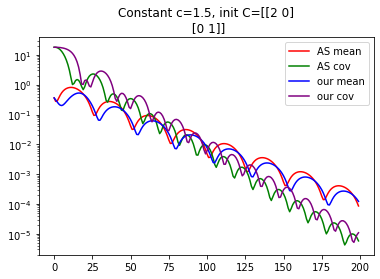

In [9]:
# parameters of the algorithm
const = 1.5
N     = 200   # iteration number 
dt    = 0.05 # step size

# initialization

m0  = np.asarray([0.2,0.3]).T 
C0  = np.diag([2,1])


# for the optimal scheme D opt and J opt are computed from the target matrix covariance K

# means and covariances along iterations
# for the optimal scheme
MM_opt = np.zeros((2,N))
CC_opt = np.zeros((2,2,N))


# distances to true mean and true covariance along iterations
dis_M_opt  = np.zeros((N,1)) 
dis_C_opt  = np.zeros((N,1))
dis_L2_opt = np.zeros((N,1))



MM_opt[:,0]   = m0
CC_opt[:,:,0] = C0

dis_M_opt[0] = np.linalg.norm(m0)
dis_C_opt[0] = np.linalg.norm(C0-K)

# construct D_opt and J_opt matrices
D_opt_tilde, v, lambda_min = construct_D_opt_tilde(K,d)
D_opt = construct_D_opt(K,d)

psis = construct_onb(d,v)
J_opt = construct_J_opt(psis, v, lambda_min, const, d, sqrtK) 
    
m, C = m0, C0    
for iter in range(1,N):
    m = m - dt*np.dot((D_opt + J_opt),np.linalg.solve(K,m)) # li has a "d - j" below and has a multiplication by C in the end
    C   = C - dt*np.dot((D_opt + J_opt),np.linalg.solve(K,C)) \
                - dt*np.dot(C, np.linalg.solve(K,(D_opt+J_opt).T)) + 2*dt*D_opt
    MM_opt[:,iter]    = m
    CC_opt[:,:,iter]  = C
    #dis_L2[iter] = weighted_L2(m, C, [0,0]', K)
    dis_M_opt[iter] = np.linalg.norm(m)
    dis_C_opt[iter] = np.linalg.norm(C-K)

# for our scheme D opt and J opt are computed from the current covariance C

# means and covariances along iterations
# for our scheme
MM = np.zeros((2,N))
CC = np.zeros((2,2,N))


# distances to true mean and true covariance along iterations
dis_M = np.zeros((N,1)) 
dis_C  = np.zeros((N,1))
dis_L2 = np.zeros((N,1))


# initialization

MM[:,0]   = m0
CC[:,:,0] = C0

dis_M[0] = np.linalg.norm(m0)
dis_C[0] = np.linalg.norm(C0-K)

m,C = m0, C0
for iter in range(1,N):
    # construct D_opt and J_opt matrices
    D_opt_tilde, v, lambda_min = construct_D_opt_tilde(C,d)
    D_opt = construct_D_opt(C,d)

    psis = construct_onb(d,v)
    sqrtC = scipy.linalg.sqrtm(C)
    J_opt = construct_J_opt(psis, v, lambda_min, const, d, sqrtC) 

    #print(iter)
    m = m - dt*np.dot((D_opt + J_opt),np.linalg.solve(K,m)) # li has a "d - j" below and has a multiplication by C in the end
    C   = C - dt*np.dot((D_opt + J_opt),np.linalg.solve(K,C)) \
                - dt*np.dot(C, np.linalg.solve(K,(D_opt+J_opt).T)) + 2*dt*D_opt
    MM[:,iter]    = m
    CC[:,:,iter]  = C
    #dis_L2[iter] = weighted_L2(m, C, [0,0]', K)
    dis_M[iter] = np.linalg.norm(m)
    dis_C[iter] = np.linalg.norm(C-K)

plt.yscale('log',base=10) 
plt.plot(range(0,N), dis_M_opt, c='red', label = 'AS mean')
plt.plot(range(0,N), dis_C_opt, c='green', label = 'AS cov')
plt.plot(range(0,N), dis_M, c='blue', label = 'our mean')
plt.plot(range(0,N), dis_C, c='purple', label = 'our cov')
plt.title('Constant c='+str(const)+', init C='+str(C0))
plt.legend()

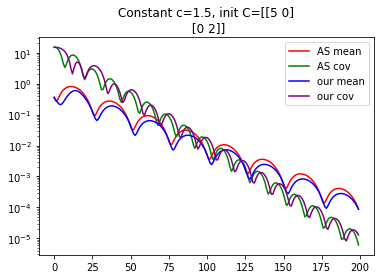

In [10]:
# parameters of the algorithm
const = 1.5
N     = 200   # iteration number 
dt    = 0.05 # step size

# initialization

m0  = np.asarray([0.2,0.3]).T 
C0  = np.diag([5,2])


# for the optimal scheme D opt and J opt are computed from the target matrix covariance K

# means and covariances along iterations
# for the optimal scheme
MM_opt = np.zeros((2,N))
CC_opt = np.zeros((2,2,N))


# distances to true mean and true covariance along iterations
dis_M_opt  = np.zeros((N,1)) 
dis_C_opt  = np.zeros((N,1))
dis_L2_opt = np.zeros((N,1))



MM_opt[:,0]   = m0
CC_opt[:,:,0] = C0

dis_M_opt[0] = np.linalg.norm(m0)
dis_C_opt[0] = np.linalg.norm(C0-K)

# construct D_opt and J_opt matrices
D_opt_tilde, v, lambda_min = construct_D_opt_tilde(K,d)
D_opt = construct_D_opt(K,d)

psis = construct_onb(d,v)
J_opt = construct_J_opt(psis, v, lambda_min, const, d, sqrtK) 
    
m, C = m0, C0    
for iter in range(1,N):
    m = m - dt*np.dot((D_opt + J_opt),np.linalg.solve(K,m)) # li has a "d - j" below and has a multiplication by C in the end
    C   = C - dt*np.dot((D_opt + J_opt),np.linalg.solve(K,C)) \
                - dt*np.dot(C, np.linalg.solve(K,(D_opt+J_opt).T)) + 2*dt*D_opt
    MM_opt[:,iter]    = m
    CC_opt[:,:,iter]  = C
    #dis_L2[iter] = weighted_L2(m, C, [0,0]', K)
    dis_M_opt[iter] = np.linalg.norm(m)
    dis_C_opt[iter] = np.linalg.norm(C-K)

# for our scheme D opt and J opt are computed from the current covariance C

# means and covariances along iterations
# for our scheme
MM = np.zeros((2,N))
CC = np.zeros((2,2,N))


# distances to true mean and true covariance along iterations
dis_M = np.zeros((N,1)) 
dis_C  = np.zeros((N,1))
dis_L2 = np.zeros((N,1))


# initialization

MM[:,0]   = m0
CC[:,:,0] = C0

dis_M[0] = np.linalg.norm(m0)
dis_C[0] = np.linalg.norm(C0-K)

m,C = m0, C0
for iter in range(1,N):
    # construct D_opt and J_opt matrices
    D_opt_tilde, v, lambda_min = construct_D_opt_tilde(C,d)
    D_opt = construct_D_opt(C,d)

    psis = construct_onb(d,v)
    sqrtC = scipy.linalg.sqrtm(C)
    J_opt = construct_J_opt(psis, v, lambda_min, const, d, sqrtC) 

    #print(iter)
    m = m - dt*np.dot((D_opt + J_opt),np.linalg.solve(K,m)) # li has a "d - j" below and has a multiplication by C in the end
    C   = C - dt*np.dot((D_opt + J_opt),np.linalg.solve(K,C)) \
                - dt*np.dot(C, np.linalg.solve(K,(D_opt+J_opt).T)) + 2*dt*D_opt
    MM[:,iter]    = m
    CC[:,:,iter]  = C
    #dis_L2[iter] = weighted_L2(m, C, [0,0]', K)
    dis_M[iter] = np.linalg.norm(m)
    dis_C[iter] = np.linalg.norm(C-K)

plt.yscale('log',base=10) 
plt.plot(range(0,N), dis_M_opt, c='red', label = 'AS mean')
plt.plot(range(0,N), dis_C_opt, c='green', label = 'AS cov')
plt.plot(range(0,N), dis_M, c='blue', label = 'our mean')
plt.plot(range(0,N), dis_C, c='purple', label = 'our cov')
plt.title('Target K = '+str(K)+', Constant c='+str(const)+', init C='+str(C0))
plt.legend()

In [11]:
# same thing, numerical issue when C0 is not in the same order as K

"""
# parameters of the algorithm
const = 1.5
N     = 200   # iteration number 
dt    = 0.05 # step size

# initialization

m0  = np.asarray([0.2,0.3]).T 
C0  = np.diag([2,5])


# for the optimal scheme D opt and J opt are computed from the target matrix covariance K

# means and covariances along iterations
# for the optimal scheme
MM_opt = np.zeros((2,N))
CC_opt = np.zeros((2,2,N))


# distances to true mean and true covariance along iterations
dis_M_opt  = np.zeros((N,1)) 
dis_C_opt  = np.zeros((N,1))
dis_L2_opt = np.zeros((N,1))



MM_opt[:,0]   = m0
CC_opt[:,:,0] = C0

dis_M_opt[0] = np.linalg.norm(m0)
dis_C_opt[0] = np.linalg.norm(C0-K)

# construct D_opt and J_opt matrices
D_opt_tilde, v, lambda_min = construct_D_opt_tilde(K,d)
D_opt = construct_D_opt(K,d)

psis = construct_onb(d,v)
J_opt = construct_J_opt(psis, v, lambda_min, const, d, sqrtK) 
    
m, C = m0, C0    
for iter in range(1,N):
    m = m - dt*np.dot((D_opt + J_opt),np.linalg.solve(K,m)) # li has a "d - j" below and has a multiplication by C in the end
    C   = C - dt*np.dot((D_opt + J_opt),np.linalg.solve(K,C)) \
                - dt*np.dot(C, np.linalg.solve(K,(D_opt+J_opt).T)) + 2*dt*D_opt
    MM_opt[:,iter]    = m
    CC_opt[:,:,iter]  = C
    #dis_L2[iter] = weighted_L2(m, C, [0,0]', K)
    dis_M_opt[iter] = np.linalg.norm(m)
    dis_C_opt[iter] = np.linalg.norm(C-K)

# for our scheme D opt and J opt are computed from the current covariance C

# means and covariances along iterations
# for our scheme
MM = np.zeros((2,N))
CC = np.zeros((2,2,N))


# distances to true mean and true covariance along iterations
dis_M = np.zeros((N,1)) 
dis_C  = np.zeros((N,1))
dis_L2 = np.zeros((N,1))


# initialization

MM[:,0]   = m0
CC[:,:,0] = C0

dis_M[0] = np.linalg.norm(m0)
dis_C[0] = np.linalg.norm(C0-K)

m,C = m0, C0
for iter in range(1,N):
    # construct D_opt and J_opt matrices
    D_opt_tilde, v, lambda_min = construct_D_opt_tilde(C,d)
    D_opt = construct_D_opt(C,d)

    psis = construct_onb(d,v)
    sqrtC = scipy.linalg.sqrtm(C)
    J_opt = construct_J_opt(psis, v, lambda_min, const, d, sqrtC) 

    #print(iter)
    m = m - dt*np.dot((D_opt + J_opt),np.linalg.solve(K,m)) # li has a "d - j" below and has a multiplication by C in the end
    C   = C - dt*np.dot((D_opt + J_opt),np.linalg.solve(K,C)) \
                - dt*np.dot(C, np.linalg.solve(K,(D_opt+J_opt).T)) + 2*dt*D_opt
    MM[:,iter]    = m
    CC[:,:,iter]  = C
    #dis_L2[iter] = weighted_L2(m, C, [0,0]', K)
    dis_M[iter] = np.linalg.norm(m)
    dis_C[iter] = np.linalg.norm(C-K)

plt.yscale('log',base=10) 
plt.plot(range(0,N), dis_M_opt, c='red', label = 'AS mean')
plt.plot(range(0,N), dis_C_opt, c='green', label = 'AS cov')
plt.plot(range(0,N), dis_M, c='blue', label = 'our mean')
plt.plot(range(0,N), dis_C, c='purple', label = 'our cov')
plt.title('Constant c='+str(const)+', init C='+str(C0))
plt.legend()
"""

error wrong angle computed


/var/folders/_t/h78tns5s2990dvmw2d6kzfyw0000gn/T/ipykernel_11892/2696461457.py:87: ComplexWarning: Casting complex values to real discards the imaginary part
  MM[:,iter]    = m
/var/folders/_t/h78tns5s2990dvmw2d6kzfyw0000gn/T/ipykernel_11892/2696461457.py:88: ComplexWarning: Casting complex values to real discards the imaginary part
  CC[:,:,iter]  = C
/Users/annakorba/Desktop/code_eks/preconditioners/preconditioners.py:29: ComplexWarning: Casting complex values to real discards the imaginary part
  theta =  math.acos(dot_product)


UnboundLocalError: local variable 'A_theta' referenced before assignment